In [3]:
# Install opencv:
!pip install opencv-python

In [4]:
# Imports:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [2]:
# Mount drive:
from google.colab import drive
drive.mount('/content/drive')

# Get images:
imagePath1 = "/content/drive/MyDrive/imgs/alf01.png"
imagePath2 = "/content/drive/MyDrive/imgs/cat01.png"
imagePath3 = "/content/drive/MyDrive/imgs/alf02.png"

Mounted at /content/drive


In [20]:
# Define the hash 256-bit decoder function:
def getHashString(inputArray):
    # Store the hash string here:
    outString = ""
    for i in range(inputArray.shape[0]):
        # Get int from array, convert to hex and then to string:
        hexChar = str(hex(inputArray[i]))
        # Discard the "0x" prefix:
        hexChar = hexChar[2:]
        # Ech int is encoded using two nibbles:
        if len(hexChar) == 1:
          # Fill the most significant nibble with "0"
          hexChar = "0" + hexChar

        # Concatenate:
        outString = outString + str(hexChar)[-2:]
    # Done:
    return outString

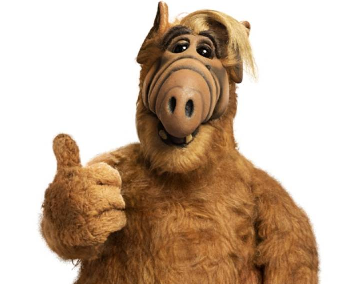

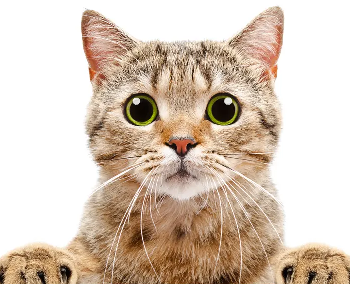

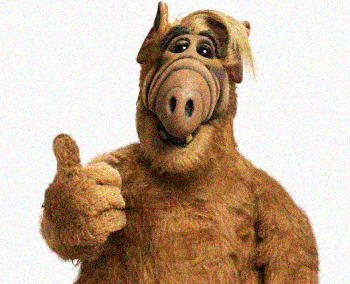

In [6]:
# The images are stored here:
imageList = []
# Check out the images:
for currentPath in [imagePath1, imagePath2, imagePath3]:
  # Read images:
  currentImage = cv2.imread(currentPath)
  # Store images:
  imageList.append(currentImage)
  cv2_imshow(currentImage)

In [21]:
# Set the "hasing scale":
imageScale = (0.3, 0.3)

# Prepare the dictionary of dupluicated hashes:
hashTable = {}

# Prepare the image hashing object:
hasher = cv2.img_hash.BlockMeanHash_create()

# Process the images:
for currentImage in imageList:

  # BGR to Gray:
  grayImage = cv2.cvtColor(currentImage, cv2.COLOR_BGR2GRAY)
  # Scale down the image by the scale factor:
  grayImage = cv2.resize(grayImage, None, fx=imageScale[0], fy=imageScale[0])

  # Compute image hash:
  imageHash = hasher.compute(currentImage)

  # print(imageHash[0])

  # Convert 32-bit array into string:
  hashString = getHashString(imageHash[0])

   # Into the hash table. Every entry is a list item:
  if hashString not in hashTable:
    # First entry:
    hashTable[hashString] = [[currentImage, True]]
  else:
    # Subsecuent entries:
    hashTable[hashString].append([currentImage, False])

# Get number of unique images:
uniqueImages = len(hashTable)
print("Unique images: ", uniqueImages)

Unique images:  3


In [23]:
# Check items on the hash table:
for key in hashTable:

  # Get dic entry:
  currentDuplicates  = hashTable[key]
  # Get key duplicates:
  totalDuplicates = len(currentDuplicates)

  # Print how many duplicates are found for this particular image (key):
  print("Examining duplicates for: ", key, "Duplicates found: ", totalDuplicates)

  # Check out duplicates:
  for i in range(totalDuplicates-1, 0, -1):

    print(" Duplicate: ", i)
    # Get the current duplicate:
    currentList = currentDuplicates[i]
    # Get duplicate flag:
    duplicateFlag = currentList[1]

    # Remove duplicate:
    if not duplicateFlag:
      hashTable[key].pop()
      print(" - Removed element: ", i)


Examining duplicates for:  ffff7ff83ff83ff83ff83ff83ff83ff813f807f003e003c003c003c007800780 Duplicates found:  1
Examining duplicates for:  ffffefe74fe10fe00ff01ff80fe00fe00ff01ff41ff20ff00fe00fe000000000 Duplicates found:  1
Examining duplicates for:  ffff7ff83ff83ff83ff83ff83ff83ff813f817f003e003c003c003c007800780 Duplicates found:  1


Key:  ffff7ff83ff83ff83ff83ff83ff83ff813f87f03e03c03c03c0780780  images:  1


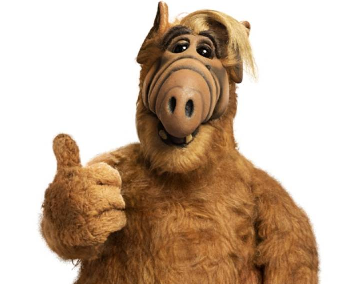

Key:  ffffefe74fe1fe0ff01ff8fe0fe0ff01ff41ff2ff0fe0fe00000  images:  1


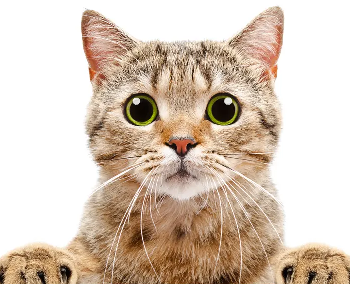

Key:  ffff7ff83ff83ff83ff83ff83ff83ff813f817f03e03c03c03c0780780  images:  1


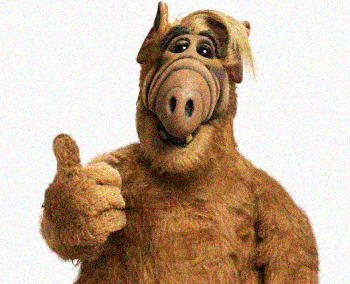

In [ ]:
# Show original images:
for key in hashTable:

  # Get image count (should be 1 -> the original entry):
  imageCount = len(hashTable[key])
  print("Key: ", key, " images: ", imageCount)

  # Get actual image
  for i in range(imageCount):
    currentImage = hashTable[key][i][0]
    cv2_imshow(currentImage)